# Machine learning for computational materials science and chemistry with MALA

## What is MALA?

A short summary about MALA and how it works is given in `mala_background.pdf`.

## Setting up MALA

For this tutorial, a Google Collab enviroment will be provided that includes all necessary packages. Generally, MALA is an open source framework that can be obtained [here](https://github.com/mala-project/mala). Detailled (installation) instructions can be found [here](https://mala-project.github.io/mala/).

A few examples at the end of the notebook tackle advanced applications. The necessary backends are, for the ease of installation, not bundled with the Google Collab environment. Interested readers may install them themselves on their machines, for in presence workshops, they will be demonstrated by the host, as are sosme aspects of data generation.

## Loading the modules

These modules will be necessary for the tutorials discussed here.

In [1]:
# MALA itself.

import mala

# We would like to visualize simple plots.
# The font size can sometimes be a bit small for Jupyter Notebooks.

import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 22}
matplotlib.rc('font', **font)

# For the data paths.
from os.path import join as pj

# Only for the prediction down below.
from ase.io import read

# To do some timings down below.
from time import time


# Data I: Performing simulations (presentation only)

Data is the backbone of each ML application. For MALA, this includes target data (some electronic structure quantity to be learned, usually the local density of states, LDOS) and some descriptor data (a vectorial field that encodes the atomic density at each point in space, usually via so called bispectrum components).

MALA data generation can be performed with the Quantum ESPRESSO package. Some changes to this open source package were necessary to enable the correct sampling of the LDOS. The current development branch of Quantum ESPRESSO includes those - beginning with Quantum ESPRESSO version 7.2 (to be released in ~June 2023) users can simply download the latest QE version and perform data generation.

Data generation is two-fold: First, one creates a set of atomic position via a regular DFT-MD simulation at the conditions of interest. This can be done with any suitable code, such as VASP, QE, etc. Secondly, one performs DFT simulations to access the LDOS.

The test system for our investigation here will be a simply beryllium system at room temperature consisting of 2 beryllium atoms. Atomic configurations have been sampled beforehand. We will start with the DFT simulation. Note: For actual data generation, the simulation output needs to be saved (usually as ".out" file) and is of course done on HPC infrastructure.

MALA data generation thus comes down to a simply DFT + Postprocessing calculation. There is one drawback though: The LDOS has to be sampled with a very high fidelity in the k-space (phase space, i.e., how the Fourier components of the basis set are sampled). The fidelity of the MALA calculation has to be higher then for standard DFT calculations, which has to be kept in mind. A good way to visualize the problem is through the density of states (LDOS integrated on real space grid) which shows unphysical oscillations for low fidelity calculations. These oscillations vanish as one moves to higher fidelity calculations.

![kpoint_comparison](./figures/DOSwdifferentdeltasandks.png)

After we have performed the actual simulation, we are halfway done. We now have simulation outputs, both the DFT output as well as the LDOS. From this we need to do two things:

1. We need to convert the LDOS into a format we actually want to work with. Cube files are unnecessarily huge, complicated both disk usage as well as speed.
2. We need to calculate the atomic density descriptors from the atomic positions.

So it's finally time to fire up MALA.

# The MALA interface (hands-on)

Within extended ML frameworks, a big problem is reproducibility. Models often depend on a lot of so called hyperparameters, that characterize model behavior. This may include, but in no way be limited to, neural network layer sizes and number, training procedures, description of data specifics (e.g.: how is the local density of states sampled?), etc.
There is a number of ways to efficiently handle this problem. A lot of frameworks rely on command line arguments to deal with this, i.e., the user provides a, potentially extensive, list of command line arguments upon runtime. Another good way to handle all this is the usage of input files. This is consistent with the way standard computational science simulation codes work.
An obvious downside to this is that one has to have a framework at hand to prepare these input files.

MALA follows a route sort of in between the two approaches. The central quantity is the `Parameters()` object. It holds ALL (hyper)parameters one could use in the course of a MALA run. It is structured by the subtasks of MALA.

In [2]:
parameters = mala.Parameters()

# All parameters related to how data is handled in general.
parameters.data

# "Targets" always refers to the quantity being learned.
parameters.targets

# "Descriptors" always refers to the quantity from which we learn.
parameters.descriptors

# "Data generation" refers to useful routines for creating training data.
# These routines are mostly experimental at the moment and will not be discussed here in detail
parameters.datageneration

# "Network" refers to everything related to neural network creation and training.
# In the future, support for more models is planned, and this collection of parameters
# will be updated to reflect this.
parameters.network

# "Hyperparameters" means hyperparameter optimization. This is the process of finding the optimal
# hyperparameters for MALA model training, and we will come back to this process later.
parameters.hyperparameters

Individual parameter objects can be printed to see what's hidden inside. This also works on the main object as well.

In [3]:
parameters.data.show()

snapshot_directories_list: []
data_splitting_type: by_snapshot
input_rescaling_type: None
output_rescaling_type: None
use_lazy_loading: False
use_clustering : False
number_of_clusters: 40
train_ratio    : 0.1
sample_ratio   : 0.5
use_fast_tensor_data_set: False
shuffling_seed : None


Finally, there are some high-level parameters one needs when performing ML at scale.

In [4]:
# Whether or not to use a GPU for model training and inference.
parameters.use_gpu

# Whether or not to use MPI parallel CPU inference (no training supported).
# This option is either for pre-processing or production runs of trained models.
# More on that later.
parameters.use_mpi

# Manual seeds can be used to fix the Pseudo RNG to re-create models with the exact
# same model weights.
parameters.manual_seed

# A comment may be useful to distinguish between sets of parameters.
parameters.comment

# This is useful for adjusting the output level of MALA.
parameters.verbosity

1

All of this does not explain how MALA handles reproducibility. Write hundreds of lines of parameter statement in each python script is not exactly maintainable.
Therefore MALA provides a .json interface.

In [5]:
parameters.save("mala_parameters_01.json")
new_parameters = mala.Parameters.load_from_file("mala_parameters_01.json")

Have a look at the .json file that was just created. You will see that it is structured in the same ways as the python object, allowing fast access. You will see some parameters that are not dicussed here since they exceed the scope of this tutorial. For a first excercise, try to modify parameters both in python and in json and see whether loading will recover those changes. The comment and manual seed are good first examples for this.

In [6]:
# Set a comment
parameters.comment = "My first parameters."

# Save.
parameters.save("mala_parameters_01.json")

In [7]:
# Edit something in the file (e.g. the manual_seed) and reload.
parameters = mala.Parameters.load_from_file("mala_parameters_01.json")
parameters.show()

---     All parameter MALA needs to perform its various tasks. ---
comment        : My first parameters.
manual_seed    : None
use_gpu        : False
device         : cpu
use_horovod    : False
use_mpi        : False
verbosity      : 1
openpmd_configuration: {}
openpmd_granularity: 1
---     Parameters necessary for constructing a neural network. ---
	nn_type        : feed-forward
	layer_sizes    : [10, 10, 10]
	layer_activations: ['Sigmoid']
	loss_function_type: mse
	num_hidden_layers: 1
	no_hidden_state: False
	bidirection    : False
	dropout        : 0.1
	num_heads      : 10
---     Parameters necessary for calculating/parsing input descriptors. ---
	descriptor_type: Bispectrum
	lammps_compute_file: 
	descriptors_contain_xyz: True
	use_z_splitting: True
	number_y_planes: 0
	bispectrum_twojmax: 10
	rcutfac        : 4.67637
	atomic_density_cutoff: 4.67637
	snap_switchflag: 1
	use_atomic_density_energy_formula: False
	atomic_density_sigma: None
---     Parameters necessary for calculat

For extended experiments, it is very useful to operate with such input files and only use the in-python parameter editing when absolutely necessary. Further, concluded experiments can be saved in this way for future reference.
In the following, we will use a combination of both approaches for the sake of transparency.

# Data II: Data preprocessing (presentation-only)

We can now start using MALA to prepare our data. MALA directly takes in calculation outputs and transforms it into formats with which we can easily work.
First, we have to decide which descriptors to calculate and how to correctly process the LDOS.

In [8]:
parameters = mala.Parameters()

# These values we will take for granted now. In the hyperparameter section we will find out
# how they are determined.
parameters.descriptors.descriptor_type = "Bispectrum"
parameters.descriptors.bispectrum_twojmax = 10
parameters.descriptors.bispectrum_cutoff = 4.67637
parameters.descriptors.descriptors_contain_xyz = True

# These values need to correspond to the ones used in the DFT simulation.
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5

Now we can use the `DataConverter` class to convert simulation outputs. File format labels follow the ASE package wherever possible!

In [4]:
%env RDMAV_FORK_SAFE=1

data_converter = mala.DataConverter(parameters)
data_converter.add_snapshot(descriptor_input_type="espresso-out",
                            descriptor_input_path="./data_generation/dft.out",
                            target_input_type=".cube",
                            target_input_path="./data_generation/tmp.pp0*Be_ldos.cube")
data_converter.convert_snapshots("./data_generation/", naming_scheme="Be_snapshot*.npy")

env: RDMAV_FORK_SAFE=1
Disabling z-splitting for preprocessing.
Calculating descriptors from ./data_generation/dft.out
Reading 11 LDOS files from./data_generation/tmp.pp0*Be_ldos.cube.


In this example we will use the [MALA test data set](https://github.com/mala-project/test-data), which contains 4 atomic configurations, including simulation output, bispectrum components and LDOS - i.e., this preprocessing has already been done for all of them.

In [2]:
data_path = "/home/fiedlerl/data/mala_data_repo/Be2"

# Visualizing and reproducing output data (hands-on)

Before we train a model, it is a good idea to think about which metric is important, i.e., how do we test if a model is good?

In essence, the advantage of MALA is the access to multiple observables. Two easily accesible metrics are the density of states (DOS) and the band energy. We will now learn how to calculate them from the LDOS (the actual DFT LDOS in this case) so we can do the same after model training to test our models.

For this, we first have to make sure the correct LDOS parameters are used.

In [11]:
parameters.targets.target_type = "LDOS"
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5

Now we can create an LDOS calculator and directly populate it with the LDOS data from the data set.

In [12]:
ldos_calculator = mala.LDOS.from_numpy_file(parameters, pj(data_path, "Be_snapshot0.out.npy"))

Afterwards, we have to read in some additional information from the simulation data (size of the real space grid, temperature, etc.).

In [13]:
ldos_calculator.read_additional_calculation_data(pj(data_path, "Be_snapshot0.out"))

Now we can access the DOS and the band energy as properties of the calculator object.

12.447077140228345


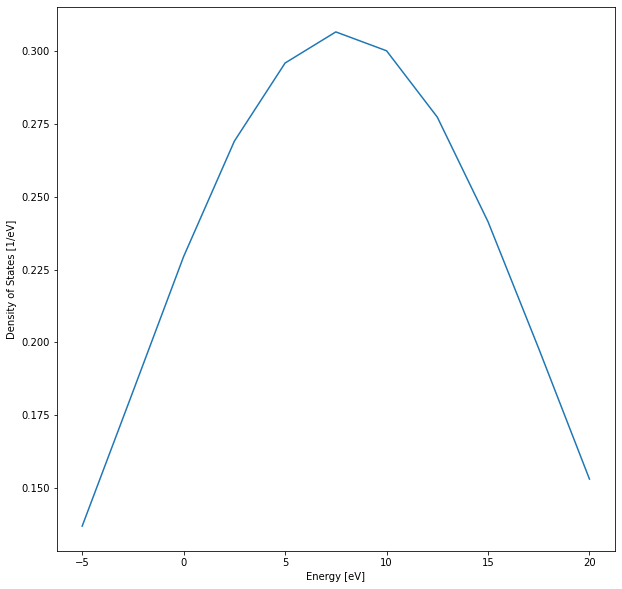

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states)

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")

print(ldos_calculator.band_energy)

# Training a model (hands-on)

Finally, we can train a neural network based model for the electronic structure. First, let us review which parameters we need for this. In the following we will slowly adapt the parameters until we get a good model out of it.

Since we want to learn about the inner workings of MALA, we want full output. We will also fix the manual seed, so that all the models are comparable.

In [15]:
parameters = mala.Parameters()
parameters.verbosity = 2
parameters.manual_seed = 2023

Since MALA provides quite a few reasonable default values, in the simplest case the only thing we have to decide upon is the data we want to learn on and the architecture of the neural network.

For each training we have to specify training (`"tr"`) and validation (`"va"`) snapshots. The former are used to actually tune the network weights, the latter monitor model performance during training. They will become very relevant as we optimize the training process.

Deciding on the layer sizes is usually done AFTER the data is loaded, since the first and last layer need to match up with the data provided.

In [16]:
data_handler = mala.DataHandler(parameters)
data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                          "Be_snapshot0.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  100,
                                  data_handler.output_dimension]

No data rescaling will be performed.
No data rescaling will be performed.
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot0.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot0.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot1.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot1.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Consistency check successful.
Initializing the data scalers.
Input scaler parametrized.
Output scaler parametrized.
Data scalers initialized.
Build datasets.
Build dataset: Done.


Now we can actually train a network.

In [17]:
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()

Initial Guess - validation data loss:  0.23660719517299106
Epoch 0: validation data loss: 2.0642450877598352e-05, training data loss: 0.0010316168240138463
Time for epoch[s]: 5.156662464141846
Epoch 1: validation data loss: 8.426698190825327e-06, training data loss: 9.5022799713271e-06
Time for epoch[s]: 0.6167004108428955
Epoch 2: validation data loss: 6.573324224778584e-06, training data loss: 4.276818728872708e-06
Time for epoch[s]: 0.7527422904968262
Epoch 3: validation data loss: 6.066970527172088e-06, training data loss: 3.2637411994593483e-06
Time for epoch[s]: 0.7921140193939209
Epoch 4: validation data loss: 5.8819215212549484e-06, training data loss: 2.9526403439896447e-06
Time for epoch[s]: 0.6670141220092773
Epoch 5: validation data loss: 5.756421280758722e-06, training data loss: 2.780921491129058e-06
Time for epoch[s]: 0.7544350624084473
Epoch 6: validation data loss: 5.729225065026964e-06, training data loss: 2.724048016326768e-06
Time for epoch[s]: 0.7185301780700684
Ep

Well, how was that? Do we have a good model now, can we predict the LDOS with this? That is not an easy question to answer from this output alone. First of all, we see loss values being printed, and those look all nice, but they are not trivially related to physical/chemical accuracy, which we are actually looking for.

We can test this by using the `Tester` class. The class works similar to the Trainer class. We add data, push them through the model, and then use the results to perform calculations.

We just have to make sure that the LDOS is correctly integrated by setting the appropriate parameters. Then we can add data to test. We should always test on data different from the one we trained on. Also, we now have to specify the corresponding calculation output, since we may need this for integration.

In [18]:
parameters.targets.ldos_gridsize = 11
parameters.targets.ldos_gridspacing_ev = 2.5
parameters.targets.ldos_gridoffset_ev = -5

data_handler.clear_data()
data_handler.add_snapshot("Be_snapshot2.in.npy", data_path,
                          "Be_snapshot2.out.npy", data_path, "te",
                          calculation_output_file=pj(data_path, "Be_snapshot2.out"))
data_handler.add_snapshot("Be_snapshot3.in.npy", data_path,
                          "Be_snapshot3.out.npy", data_path, "te",
                          calculation_output_file=pj(data_path, "Be_snapshot3.out"))
data_handler.prepare_data(reparametrize_scaler=False)


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot2.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot2.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot3.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot3.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


Now comes the actual object with which to test. We simply tell it which observables to test for and off we go.

In [19]:
tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])
results = tester.test_all_snapshots()


Had to readjust batch size from 10 to 12


The results are given as a dictionary and in the units of meV/atom.

In [20]:
results

{'band_energy': [-0.0352251206432328, -0.02902837244603873]}

That already looks pretty solid. On the machine this notebook was tested on, errors below 0.1 meV/atom were reported, i.e., the network reproduces the band energy excellently. We may also visualize the DOS, and will do so later, but for now let's focus on the band energy. Can we get even better results? Of course, for simple data like this, we already seem to be doing a good job. But larger and more diverse data sets can be tricky.

So let us see if we can improve the training routine even further. To do so, first let's rewrite the code above into functions so that we can toy around with them.

In [4]:
def training(parameters):
    data_handler = mala.DataHandler(parameters)
    data_handler.clear_data()

    data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                              "Be_snapshot0.out.npy", data_path, "tr")
    data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                              "Be_snapshot1.out.npy", data_path, "va")

    # This already loads data into RAM!
    data_handler.prepare_data()
    parameters.network.layer_sizes.insert(0, data_handler.input_dimension)
    parameters.network.layer_sizes.append(data_handler.output_dimension)
    network = mala.Network(parameters)
    trainer = mala.Trainer(parameters, network, data_handler)
    trainer.train_network()


    return parameters, data_handler, network

def testing(parameters, data_handler, network):

    parameters.targets.ldos_gridsize = 11
    parameters.targets.ldos_gridspacing_ev = 2.5
    parameters.targets.ldos_gridoffset_ev = -5

    data_handler.clear_data()
    data_handler.add_snapshot("Be_snapshot2.in.npy", data_path,
                              "Be_snapshot2.out.npy", data_path, "te",
                              calculation_output_file=pj(data_path, "Be_snapshot2.out"))
    data_handler.add_snapshot("Be_snapshot3.in.npy", data_path,
                              "Be_snapshot3.out.npy", data_path, "te",
                              calculation_output_file=pj(data_path, "Be_snapshot3.out"))
    data_handler.prepare_data(reparametrize_scaler=False)

    tester = mala.Tester(parameters, network, data_handler, observables_to_test=["band_energy"])
    results = tester.test_all_snapshots()
    return results


Now let's see what happens if we start changing up the parameters. Let's start with those that influence the network architecture first. If we define the functions in an appropriate way, we can easily manipulate layer sizes of the neural networks for instance. What happens if we choose a ridiculously small number of neurons for the hidden layer? What happens if we choose a large number? Try e.g. 2 or 1000 as number for the hidden layer (the one in between).

In [22]:
parameters = mala.Parameters()
parameters.verbosity = 2
parameters.manual_seed = 2023
parameters.network.layer_sizes = [1000]

parameters, data_handler, network = training(parameters)
print(testing(parameters, data_handler, network))


No data rescaling will be performed.
No data rescaling will be performed.
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot0.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot0.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot1.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot1.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Consistency check successful.
Initializing the data scalers.
Input scaler parametrized.
Output scaler parametrized.
Data scalers initialized.
Build datasets.
Build dataset: Done.
Initial Guess - validation data loss:  0.244789306640625
Epoch 0: validation data loss: 5.834028124809265e-06, training data loss: 0.00029535348074776786
Time for epoch[s]: 1.8992931842803955
Epoch 1: validation data loss: 5.244482308626175e-06, training data loss: 2.741139116031783e-06
Time for epoch[s]: 1.7302265167236328
Epoch 2: validati

Ok, so this clearly has an effect. We can build better and worse models by simply adjusting this number. Models that are too small don't have enough information capacity - they simply cannot capture the information present in the data. This is called **underfitting**.

But also big models (if you haven't tried - try e.g. 1000 neurons!) do not yield immediate improvement. In my case, 1000 neurons in the middle gave noticeably worse performance.

Why is that? Large models possess a large capacity to store information. If they are not carefully fitted, they may very soon begin to **overfit**, i.e. learn to predict the training data - and only the training data. This is obviously not what is supposed to happen.

This is what the aforementioned validation data is for. Validation data is data unseen by the model during the weight optimization, but checked after each epoch. The idea is simple: Since the model is not directly fitted on the validation data, we can use it to monitor fitting progress. If validation accuracy is drastically different from training accuracy, something is off.

If you check your outputs, you will realize that both losses behave differently for different models. In the 1000 neuron case at the end you will encounter a factor of 10 between both of them! For a smaller model, it was only 2.

There is one way to alleviate this: Early stopping. The idea is to end training prematurely if we see validation accuracy stagnating for a certain amount of time, i.e., the model starting to overfit. MALA supports this with a simple command. Let's try it out with 1000 neurons.

In [22]:
parameters = mala.Parameters()
parameters.verbosity = 2
parameters.manual_seed = 2023
parameters.network.layer_sizes = [1000]
parameters.running.early_stopping_epochs = 4

parameters, data_handler, network = training(parameters)
print(testing(parameters, data_handler, network))


No data rescaling will be performed.
No data rescaling will be performed.
Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot0.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot0.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot1.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot1.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Consistency check successful.
Initializing the data scalers.
Input scaler parametrized.
Output scaler parametrized.
Data scalers initialized.
Build datasets.
Build dataset: Done.
Initial Guess - validation data loss:  0.244789306640625
Epoch 0: validation data loss: 5.834028124809265e-06, training data loss: 0.00029535348074776786
Time for epoch[s]: 1.2693874835968018
Epoch 1: validation data loss: 5.244482308626175e-06, training data loss: 2.741139116031783e-06
Time for epoch[s]: 1.1986780166625977
Epoch 2: validati

In my case, that helped a tiny bit with the accuracy of one snapshot. So we're getting there. Before we overthinking this specific aspect, let's introduce some more hyperparameters and test them out. We can toy with the length of the training, the learning rate (i.e. the aggressivness of the gradient updates of the neural networks, large learning rates mean larger updates per epoch, which can lead to oscillations, small learning rates can lead to stagnation) and the optimizer being used.

In [ ]:
parameters = mala.Parameters()
parameters.verbosity = 2
parameters.manual_seed = 2023
parameters.network.layer_sizes = [100]
parameters.running.early_stopping_epochs = 4
# Default value is 100 - try out longer trainings as well. Or shorter!
parameters.running.max_number_epochs = 100
# Default value is 0.5 - try out a few!
parameters.running.learning_rate = 0.5
# Default value is SGD - try out Adam instead!
parameters.running.trainingtype = "SGD"

parameters, data_handler, network = training(parameters)
print(testing(parameters, data_handler, network))


You may beginning to feel a bit overwhelmed by all the choices one can make here. We'll address this very real struggle in a second, but we'll just add a bit more gasoline to the fire while were at it.

There are two aspects of ML that can be very important (and that MALA supports) that we have not yet talked about.

The first is data scaling. The idea behind data scaling is to make data more uniform - vectorial fields as in our case may contain larger and smaller components per data point and it can be hard for a network to correctly learn this. By normalizing or standardizing data, performance is often improved. MALA supports normalization feature-wise or per entire dataset. Empirically, we have made good experiences with the following. (Be aware: if you change the scaling, the absolute loss values will inevitably change - this is why we monitor the band energy.)

In [23]:
parameters = mala.Parameters()
parameters.verbosity = 2
parameters.manual_seed = 2023
parameters.network.layer_sizes = [100]
parameters.data.input_rescaling_type = "feature-wise-standard"
parameters.data.output_rescaling_type = "normal"


parameters, data_handler, network = training(parameters)
print(testing(parameters, data_handler, network))


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot0.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot0.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot1.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot1.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Consistency check successful.
Initializing the data scalers.
Input scaler parametrized.
Output scaler parametrized.
Data scalers initialized.
Build datasets.
Build dataset: Done.
Initial Guess - validation data loss:  0.054730381556919644
Epoch 0: validation data loss: 0.002600432804652623, training data loss: 0.0017240849903651645
Time for epoch[s]: 0.5689492225646973
Epoch 1: validation data loss: 0.002115297998700823, training data loss: 0.0007406753131321499
Time for epoch[s]: 0.5992138385772705
Epoch 2: validation data loss: 0.001884244918823242, training data loss: 0.0005785423687526

In my case, adding the data scaling improved performance drastically. Feel free to try out other forms of scaling (for no scaling, just specify `"None"`).

Secondly, we can adapt the activation functions of the neural net, i.e., the linear transformation at the end of each layer. In MALA, this is realized by a list as well. We can specify individual layers, or simply give only one type to be used at each layer.

In [23]:
parameters = mala.Parameters()
parameters.verbosity = 2
parameters.manual_seed = 2023
parameters.network.layer_sizes = [100]
parameters.data.input_rescaling_type = "feature-wise-standard"
parameters.data.output_rescaling_type = "normal"

# Sigmoid is default, try out ReLU or LeakyReLU!
parameters.network.layer_activations = ["LeakyReLU"]


parameters, data_handler, network = training(parameters)
print(testing(parameters, data_handler, network))


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot0.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot0.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot1.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot1.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Consistency check successful.
Initializing the data scalers.
Input scaler parametrized.
Output scaler parametrized.
Data scalers initialized.
Build datasets.
Build dataset: Done.
Initial Guess - validation data loss:  0.1100400652204241
Epoch 0: validation data loss: 0.005833011082240514, training data loss: 0.0018355793271745955
Time for epoch[s]: 0.4657137393951416
Epoch 1: validation data loss: 0.005376566750662668, training data loss: 0.00023572427885872976
Time for epoch[s]: 0.4514944553375244
Epoch 2: validation data loss: 0.004776518140520368, training data loss: 0.00013633434261594

As you will have noticed, the result seem to vary quite a bit.

So what do we make of all of this?
We can build different models, and they give different accuracy. But that's also dependent on the data scaling to be used. And that is also dependent on the way we train them. What now?

Well, welcome to hell. This complexity is what makes (deep) ML hard, just as the obvious speed-up makes it worthwhile.

There are two important concepts at play here:

1. Intuition and experience - understanding your data. Your data has inherent structure that can be exploited in several ways. As a rule of thumb activation functions may be chosen in a way that reflects the data itself, i.e. if we have a lot of smooth curves, Sigmoid functions may work well (they do here). LeakyReLU on the other hand is a standard choice for more complicated data. Model size should reflect the complexity in your data set, and a simple data set does not warrant a huge model. We have seen this just now. Training routines should be optimized for the model.
2. Good, old fashioned non-linear optimization. Essentially we have a N-dimensional hypersphere with some distinct or float valued choices and can simply test out all the combinations.

The best possible route is a combination of the two. By adding as much prior experience from 1. into 2. we can perform a limited optimization and still end up with the best possible model.

# Tuning the Hyperparameters (hands-on)

MALA provides a convenient way to tune the hyperparameters of models. There are multiple algorithms implemented, but we will focus on the `optuna` library, to which MALA provides an interface. The idea is easy: we give MALA a set of hyperparameters to optimize, fix the others, give it some data and let optuna do its work. Optuna internally uses elaborate algorithms to determine optimal hyperparameters from observed data.

First, let us think about which hyperparameters to fix. We want to fix as many as possible and reasonable to get the best trade-off between optimal results and minimal computational effort.


In [16]:
parameters = mala.Parameters()
parameters.verbosity = 2
parameters.manual_seed = 2023
parameters.data.input_rescaling_type = "feature-wise-standard"
parameters.data.output_rescaling_type = "normal"
parameters.running.max_number_epochs = 100
parameters.running.mini_batch_size = 40
parameters.running.trainingtype = "SGD"

Now we can specify data to be used.


In [17]:
data_handler = mala.DataHandler(parameters)
data_handler.clear_data()

data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                          "Be_snapshot0.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot0.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot0.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot1.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot1.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Consistency check successful.
Initializing the data scalers.
Input scaler parametrized.
Output scaler parametrized.
Data scalers initialized.
Build datasets.
Build dataset: Done.


Before we instantiate the hyperparameter optimizer, two important parameters to set are

1. The number of trials (test networks) to train
2. How often to train a test network - if we train each proposed network a number of times and evaluate the average performant, we can discard unrobust outliers. In the interest of time, let's keep it at 1 here.

In [18]:
parameters.hyperparameters.n_trials = 20
parameters.hyperparameters.number_training_per_trial = 1

hyperoptimizer = mala.HyperOptOptuna(parameters, data_handler)

hyperoptimizer.add_hyperparameter("categorical", "learning_rate",
                                     choices=[0.1, 0.2, 0.5])
hyperoptimizer.add_hyperparameter("categorical", "ff_neurons_layer_00", choices=[10, 100, 200])
hyperoptimizer.add_hyperparameter("categorical", "ff_neurons_layer_01", choices=[10, 100, 200])
hyperoptimizer.add_hyperparameter("categorical", "early_stopping_epochs", choices=[4, 8])

# Choices for activation function at each layer will be optimized.
hyperoptimizer.add_hyperparameter("categorical", "layer_activation_00",
                                  choices=["ReLU", "Sigmoid", "LeakyReLU"])


/home/fiedlerl/.local/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:263: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-03-16 18:19:49,411] A new study created in memory with name: no-name-d0b5918b-51a5-4476-a70b-c51934651e29


The syntax is a bit clunky at times, since we are trying to cramp a complicated system into a few function calls. Now let's run. This may take a while. Grab a coffee and sit back :)


In [19]:
hyperoptimizer.perform_study()

# Will save the results directly to the parameters.
hyperoptimizer.set_optimal_parameters()


Initial Guess - validation data loss:  0.13116421982577947
Epoch 0: validation data loss: 0.0031034954606670223, training data loss: 0.008716743286341836
Time for epoch[s]: 0.4891629219055176
Epoch 1: validation data loss: 0.0025456060557604923, training data loss: 0.0005864466978534716
Time for epoch[s]: 0.4613478183746338
Epoch 2: validation data loss: 0.0023794136090910054, training data loss: 0.0003730091670332434
Time for epoch[s]: 0.43048954010009766
Epoch 3: validation data loss: 0.0021896199004290853, training data loss: 0.00028405842035328415
Time for epoch[s]: 0.4212949275970459
Epoch 4: validation data loss: 0.0021643593703230767, training data loss: 0.0002323468492183511
Time for epoch[s]: 0.4008748531341553
Epoch 5: validation data loss: 0.0020938209474903264, training data loss: 0.00019799883915409106
Time for epoch[s]: 0.4379880428314209
Epoch 6: validation data loss: 0.0021044136998860257, training data loss: 0.00017276930210252876
Validation accuracy has not improved e

[I 2023-03-16 18:19:58,721] Trial 0 finished with value: 0.0020488141334220156 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 200, 'ff_neurons_layer_01': 100, 'early_stopping_epochs': 4, 'layer_activation_00': 'ReLU'}. Best is trial 0 with value: 0.0020488141334220156.


Epoch 15: validation data loss: 0.0020488141334220156, training data loss: 8.603363174553876e-05
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 4 epochs.
Final validation data loss:  0.0020488141334220156
Initial Guess - validation data loss:  0.06764695851225831
Epoch 0: validation data loss: 0.018154446937177823, training data loss: 0.03201883350877457
Time for epoch[s]: 0.32109928131103516
Epoch 1: validation data loss: 0.00959580674019034, training data loss: 0.009023511246459125
Time for epoch[s]: 0.3770270347595215
Epoch 2: validation data loss: 0.007900271241523359, training data loss: 0.004891595884000874
Time for epoch[s]: 0.3513503074645996
Epoch 3: validation data loss: 0.007445743639175206, training data loss: 0.004006068183951182
Time for epoch[s]: 0.39811277389526367
Epoch 4: validation data loss: 0.007277229605200084, training data loss: 0.0037422215557533856
Time for epoch[s]: 0.3457455635070801
Epoch 5: vali

[I 2023-03-16 18:20:34,690] Trial 1 finished with value: 0.002954056001689336 and parameters: {'learning_rate': 0.1, 'ff_neurons_layer_00': 100, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 4, 'layer_activation_00': 'Sigmoid'}. Best is trial 0 with value: 0.0020488141334220156.


Epoch 99: validation data loss: 0.002954056001689336, training data loss: 0.001100732243224366
Time for epoch[s]: 0.29711294174194336
Final validation data loss:  0.002954056001689336
Initial Guess - validation data loss:  0.13168105904914473
Epoch 0: validation data loss: 0.003099715600819348, training data loss: 0.00836452555983034
Time for epoch[s]: 0.4091203212738037
Epoch 1: validation data loss: 0.002546436982612087, training data loss: 0.0005816882603789029
Time for epoch[s]: 0.6953225135803223
Epoch 2: validation data loss: 0.0023768721105845553, training data loss: 0.0003706208306904797
Time for epoch[s]: 0.6937787532806396
Epoch 3: validation data loss: 0.0021895511781788307, training data loss: 0.00028284489428071673
Time for epoch[s]: 0.49350452423095703
Epoch 4: validation data loss: 0.002161558360269625, training data loss: 0.00023146063837830878
Time for epoch[s]: 0.5338320732116699
Epoch 5: validation data loss: 0.0020894713053420254, training data loss: 0.0001971944826

[I 2023-03-16 18:21:20,210] Trial 2 finished with value: 0.001890825218261649 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 200, 'ff_neurons_layer_01': 100, 'early_stopping_epochs': 8, 'layer_activation_00': 'LeakyReLU'}. Best is trial 2 with value: 0.001890825218261649.


Epoch 82: validation data loss: 0.001890825218261649, training data loss: 2.424158666231861e-05
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 8 epochs.
Final validation data loss:  0.001890825218261649
Initial Guess - validation data loss:  0.1280695684424274
Epoch 0: validation data loss: 0.026301059548713302, training data loss: 0.058791334770585846
Time for epoch[s]: 0.3642561435699463
Epoch 1: validation data loss: 0.019513974995373592, training data loss: 0.017112139697488586
Time for epoch[s]: 0.47178101539611816
Epoch 2: validation data loss: 0.007752214936905256, training data loss: 0.013614544585415217
Time for epoch[s]: 0.37454867362976074
Epoch 3: validation data loss: 0.004707333159773317, training data loss: 0.0022906606600164824
Time for epoch[s]: 0.3091104030609131
Epoch 4: validation data loss: 0.00394625043215817, training data loss: 0.0012456377347310383
Time for epoch[s]: 0.29473066329956055
Epoch 5: vali

[I 2023-03-16 18:21:44,639] Trial 3 finished with value: 0.0011358471357659117 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'LeakyReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 99: validation data loss: 0.0011358471357659117, training data loss: 4.404742423802206e-05
Validation accuracy has not improved enough.
Time for epoch[s]: 0.30678653717041016
Final validation data loss:  0.0011358471357659117
Initial Guess - validation data loss:  0.056024612357082976
Epoch 0: validation data loss: 0.007264077935588959, training data loss: 0.00581682218264227
Time for epoch[s]: 0.48567914962768555
Epoch 1: validation data loss: 0.00719345378004797, training data loss: 0.003626645155693298
Time for epoch[s]: 0.5095164775848389
Epoch 2: validation data loss: 0.0071079567687152186, training data loss: 0.003570293454819074
Time for epoch[s]: 0.6570956707000732
Epoch 3: validation data loss: 0.0070283407490003055, training data loss: 0.003512501172279114
Time for epoch[s]: 0.5809929370880127
Epoch 4: validation data loss: 0.006942951515929339, training data loss: 0.003453353768614329
Time for epoch[s]: 0.6433019638061523
Epoch 5: validation data loss: 0.00683163399021

[I 2023-03-16 18:22:28,472] Trial 4 finished with value: 0.0018973287926416964 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 100, 'ff_neurons_layer_01': 100, 'early_stopping_epochs': 8, 'layer_activation_00': 'Sigmoid'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 99: validation data loss: 0.0018973287926416964, training data loss: 0.0005569027643225508
Time for epoch[s]: 0.36545395851135254
Final validation data loss:  0.0018973287926416964
Initial Guess - validation data loss:  0.1221297799724422
Epoch 0: validation data loss: 0.0030802387625115104, training data loss: 0.007001734215374951
Time for epoch[s]: 0.3285703659057617
Epoch 1: validation data loss: 0.0024007417295621412, training data loss: 0.0005932767369431447
Time for epoch[s]: 0.31640005111694336
Epoch 2: validation data loss: 0.0021296640237172446, training data loss: 0.0003707124490171807
Time for epoch[s]: 0.3238701820373535
Epoch 3: validation data loss: 0.0019581026682570645, training data loss: 0.0002778194606576336
Time for epoch[s]: 0.3413374423980713
Epoch 4: validation data loss: 0.0018572872632170376, training data loss: 0.0002251100900782842
Time for epoch[s]: 0.3785369396209717
Epoch 5: validation data loss: 0.0018416523389075989, training data loss: 0.000191403

[I 2023-03-16 18:23:12,550] Trial 5 finished with value: 0.0014523690966166318 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 100, 'ff_neurons_layer_01': 200, 'early_stopping_epochs': 8, 'layer_activation_00': 'ReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 98: validation data loss: 0.0014523690966166318, training data loss: 2.183109419803097e-05
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 8 epochs.
Final validation data loss:  0.0014523690966166318
Initial Guess - validation data loss:  0.12340168539247556
Epoch 0: validation data loss: 0.002214156329359638, training data loss: 0.005744568833477421
Time for epoch[s]: 0.3831493854522705
Epoch 1: validation data loss: 0.0018462971465228355, training data loss: 0.00030026843422624076
Time for epoch[s]: 0.4105203151702881
Epoch 2: validation data loss: 0.0017654684852791704, training data loss: 0.00019764947836801885
Time for epoch[s]: 0.3248622417449951
Epoch 3: validation data loss: 0.0016132699300165046, training data loss: 0.00015249868778333272
Time for epoch[s]: 0.2972555160522461
Epoch 4: validation data loss: 0.001583177341173773, training data loss: 0.0001258874167454297
Time for epoch[s]: 0.307666540145874
Epoch

[I 2023-03-16 18:23:33,517] Trial 6 finished with value: 0.0011616977926802961 and parameters: {'learning_rate': 0.5, 'ff_neurons_layer_00': 100, 'ff_neurons_layer_01': 100, 'early_stopping_epochs': 4, 'layer_activation_00': 'LeakyReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 58: validation data loss: 0.0011616977926802961, training data loss: 1.8862692732789202e-05
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 4 epochs.
Final validation data loss:  0.0011616977926802961
Initial Guess - validation data loss:  0.09179015137833547
Epoch 0: validation data loss: 0.004120888775342131, training data loss: 0.005378122743406252
Time for epoch[s]: 0.3768033981323242
Epoch 1: validation data loss: 0.003531540909858599, training data loss: 0.0005750323403371524
Time for epoch[s]: 0.351182222366333
Epoch 2: validation data loss: 0.003356931416411378, training data loss: 0.0003638046381136054
Time for epoch[s]: 0.325484037399292
Epoch 3: validation data loss: 0.0032717079332430067, training data loss: 0.0002684506957661616
Time for epoch[s]: 0.2965230941772461
Epoch 4: validation data loss: 0.0033669199573394914, training data loss: 0.00020465196948073227
Validation accuracy has not improved enough.
T

[I 2023-03-16 18:24:06,344] Trial 7 finished with value: 0.002178017135080137 and parameters: {'learning_rate': 0.5, 'ff_neurons_layer_00': 100, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'ReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 99: validation data loss: 0.002178017135080137, training data loss: 1.1871682616061272e-05
Time for epoch[s]: 0.3805816173553467
Final validation data loss:  0.002178017135080137
Initial Guess - validation data loss:  0.12288565613907766
Epoch 0: validation data loss: 0.0036933119982889254, training data loss: 0.008292464360798875
Time for epoch[s]: 0.24950146675109863
Epoch 1: validation data loss: 0.0027088280682150087, training data loss: 0.0008328467199247178
Time for epoch[s]: 0.2451467514038086
Epoch 2: validation data loss: 0.0022929724492983185, training data loss: 0.0005457040313716348
Time for epoch[s]: 0.2697768211364746
Epoch 3: validation data loss: 0.0020916245571554522, training data loss: 0.00042429073080080287
Time for epoch[s]: 0.2924776077270508
Epoch 4: validation data loss: 0.0019485584404914892, training data loss: 0.00035034065649389677
Time for epoch[s]: 0.309525728225708
Epoch 5: validation data loss: 0.0018989952731894575, training data loss: 0.000302225

[I 2023-03-16 18:24:29,562] Trial 8 finished with value: 0.0014414896159411566 and parameters: {'learning_rate': 0.1, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 200, 'early_stopping_epochs': 8, 'layer_activation_00': 'LeakyReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 98: validation data loss: 0.0014787660613996252, training data loss: 3.6752765751592645e-05
Validation accuracy has not improved enough.
Time for epoch[s]: 0.1800704002380371
Epoch 99: validation data loss: 0.0014414896159411566, training data loss: 3.626585840226308e-05
Time for epoch[s]: 0.18466806411743164
Final validation data loss:  0.0014414896159411566
Initial Guess - validation data loss:  0.06764695851225831
Epoch 0: validation data loss: 0.009591757979022857, training data loss: 0.020574212618614442
Time for epoch[s]: 0.22106122970581055
Epoch 1: validation data loss: 0.00744390542104364, training data loss: 0.0044461028760971
Time for epoch[s]: 0.19718670845031738
Epoch 2: validation data loss: 0.007192898014364722, training data loss: 0.0036868755131551664
Time for epoch[s]: 0.20062875747680664
Epoch 3: validation data loss: 0.007099978455669804, training data loss: 0.003569377339593896
Time for epoch[s]: 0.20126628875732422
Epoch 4: validation data loss: 0.0070352167

[I 2023-03-16 18:24:53,297] Trial 9 finished with value: 0.0021281216514709334 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 100, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 4, 'layer_activation_00': 'Sigmoid'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 99: validation data loss: 0.0021281216514709334, training data loss: 0.000612817534573002
Time for epoch[s]: 0.2605936527252197
Final validation data loss:  0.0021281216514709334
Initial Guess - validation data loss:  0.1280695684424274
Epoch 0: validation data loss: 0.026301059548713302, training data loss: 0.058791334770585846
Time for epoch[s]: 0.20139527320861816
Epoch 1: validation data loss: 0.019513974995373592, training data loss: 0.017112139697488586
Time for epoch[s]: 0.18784689903259277
Epoch 2: validation data loss: 0.007752214936905256, training data loss: 0.013614544585415217
Time for epoch[s]: 0.21660113334655762
Epoch 3: validation data loss: 0.004707333159773317, training data loss: 0.0022906606600164824
Time for epoch[s]: 0.17567706108093262
Epoch 4: validation data loss: 0.00394625043215817, training data loss: 0.0012456377347310383
Time for epoch[s]: 0.1623060703277588
Epoch 5: validation data loss: 0.0034004180398705887, training data loss: 0.0009438537027193

[I 2023-03-16 18:25:12,277] Trial 10 finished with value: 0.0011358471357659117 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'LeakyReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 98: validation data loss: 0.0011327926698885007, training data loss: 4.4318868621299256e-05
Time for epoch[s]: 0.2080836296081543
Epoch 99: validation data loss: 0.0011358471357659117, training data loss: 4.404742423802206e-05
Validation accuracy has not improved enough.
Time for epoch[s]: 0.16459155082702637
Final validation data loss:  0.0011358471357659117
Initial Guess - validation data loss:  0.1280695684424274
Epoch 0: validation data loss: 0.026301059548713302, training data loss: 0.058791334770585846
Time for epoch[s]: 0.21883797645568848
Epoch 1: validation data loss: 0.019513974995373592, training data loss: 0.017112139697488586
Time for epoch[s]: 0.18810272216796875
Epoch 2: validation data loss: 0.007752214936905256, training data loss: 0.013614544585415217
Time for epoch[s]: 0.18593668937683105
Epoch 3: validation data loss: 0.004707333159773317, training data loss: 0.0022906606600164824
Time for epoch[s]: 0.19894647598266602
Epoch 4: validation data loss: 0.00394625

[I 2023-03-16 18:25:30,224] Trial 11 finished with value: 0.0011358471357659117 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'LeakyReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 99: validation data loss: 0.0011358471357659117, training data loss: 4.404742423802206e-05
Validation accuracy has not improved enough.
Time for epoch[s]: 0.19087958335876465
Final validation data loss:  0.0011358471357659117
Initial Guess - validation data loss:  0.03549702091304135
Epoch 0: validation data loss: 0.007443305564253298, training data loss: 0.007697469567599362
Time for epoch[s]: 0.18587732315063477
Epoch 1: validation data loss: 0.0071638642925105685, training data loss: 0.0036426956795121983
Time for epoch[s]: 0.20367908477783203
Epoch 2: validation data loss: 0.007025104135138804, training data loss: 0.0035155352936487765
Time for epoch[s]: 0.23240351676940918
Epoch 3: validation data loss: 0.006879740654061374, training data loss: 0.0034213610435729703
Time for epoch[s]: 0.18172168731689453
Epoch 4: validation data loss: 0.006718869622983889, training data loss: 0.0033213003585327704
Time for epoch[s]: 0.16357183456420898
Epoch 5: validation data loss: 0.006522

[I 2023-03-16 18:25:46,764] Trial 12 finished with value: 0.0013101344511389189 and parameters: {'learning_rate': 0.5, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'Sigmoid'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 99: validation data loss: 0.0013101344511389189, training data loss: 0.00042503252285256234
Time for epoch[s]: 0.1467752456665039
Final validation data loss:  0.0013101344511389189
Initial Guess - validation data loss:  0.12583412971670768
Epoch 0: validation data loss: 0.04873248757837025, training data loss: 0.053158407341944026
Time for epoch[s]: 0.20953750610351562
Epoch 1: validation data loss: 0.047858508210203966, training data loss: 0.04463234121940996
Time for epoch[s]: 0.1931595802307129
Epoch 2: validation data loss: 0.047530753427444526, training data loss: 0.044215402646696184
Time for epoch[s]: 0.21114778518676758
Epoch 3: validation data loss: 0.04721094593065515, training data loss: 0.04397757630369979
Time for epoch[s]: 0.22073936462402344
Epoch 4: validation data loss: 0.046956550040745844, training data loss: 0.04378965456191808
Time for epoch[s]: 0.24571967124938965
Epoch 5: validation data loss: 0.028033289190841047, training data loss: 0.0331163079771277
Tim

[I 2023-03-16 18:25:54,787] Trial 13 finished with value: 0.002215350463510104 and parameters: {'learning_rate': 0.1, 'ff_neurons_layer_00': 200, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'LeakyReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 33: validation data loss: 0.002215350463510104, training data loss: 7.152005383685299e-05
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 8 epochs.
Final validation data loss:  0.002215350463510104
Initial Guess - validation data loss:  0.1274287602672838
Epoch 0: validation data loss: 0.04322640754316495, training data loss: 0.0699090304440015
Time for epoch[s]: 0.1743481159210205
Epoch 1: validation data loss: 0.036454901847665165, training data loss: 0.03378032440464246
Time for epoch[s]: 0.15986132621765137
Epoch 2: validation data loss: 0.03553532247673975, training data loss: 0.03209539744407619
Time for epoch[s]: 0.15246057510375977
Epoch 3: validation data loss: 0.03361558696450708, training data loss: 0.031105461730260284
Time for epoch[s]: 0.1582474708557129
Epoch 4: validation data loss: 0.021796770836120326, training data loss: 0.022263585704646698
Time for epoch[s]: 0.15671539306640625
Epoch 5: validation d

[I 2023-03-16 18:26:04,836] Trial 14 finished with value: 0.018540384562592528 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'ReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 66: validation data loss: 0.018540384562592528, training data loss: 0.01693285872402801
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 8 epochs.
Final validation data loss:  0.018540384562592528
Initial Guess - validation data loss:  0.12288565613907766
Epoch 0: validation data loss: 0.0026069634581265383, training data loss: 0.004722176077159028
Time for epoch[s]: 0.15066003799438477
Epoch 1: validation data loss: 0.002033612771665669, training data loss: 0.0004890525381859035
Time for epoch[s]: 0.1601414680480957
Epoch 2: validation data loss: 0.0017685109077523289, training data loss: 0.0003296653633792651
Time for epoch[s]: 0.17962145805358887
Epoch 3: validation data loss: 0.0017220768482173415, training data loss: 0.0002538146935913661
Time for epoch[s]: 0.1816389560699463
Epoch 4: validation data loss: 0.0016750494639078777, training data loss: 0.00020734605179529756
Time for epoch[s]: 0.18472027778625488
Epoch 

[I 2023-03-16 18:26:06,765] Trial 15 finished with value: 0.0016805884772784089 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 200, 'early_stopping_epochs': 4, 'layer_activation_00': 'LeakyReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 10: validation data loss: 0.0016805884772784089, training data loss: 0.00011435287183822562
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 4 epochs.
Final validation data loss:  0.0016805884772784089
Initial Guess - validation data loss:  0.09215880964444653
Epoch 0: validation data loss: 0.00593201156076231, training data loss: 0.010470476324699786
Time for epoch[s]: 0.20074081420898438
Epoch 1: validation data loss: 0.004574376698498312, training data loss: 0.0012840194517074654
Time for epoch[s]: 0.18827247619628906
Epoch 2: validation data loss: 0.003997712919156845, training data loss: 0.0007375256247716407
Time for epoch[s]: 0.18925833702087402
Epoch 3: validation data loss: 0.003648150184927466, training data loss: 0.0005437841290208302
Time for epoch[s]: 0.18473458290100098
Epoch 4: validation data loss: 0.0037175729938838035, training data loss: 0.00044662855803694355
Validation accuracy has not improved enoug

[I 2023-03-16 18:26:09,852] Trial 16 finished with value: 0.0034197612440205055 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 100, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'LeakyReLU'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 14: validation data loss: 0.0034197612440205055, training data loss: 0.00016407794467934736
Validation accuracy has not improved enough.
Stopping the training, validation accuracy has not improved for 8 epochs.
Final validation data loss:  0.0034197612440205055
Initial Guess - validation data loss:  0.050907988526505424
Epoch 0: validation data loss: 0.008378724529318614, training data loss: 0.014638773382526555
Time for epoch[s]: 0.21814537048339844
Epoch 1: validation data loss: 0.00738954163033124, training data loss: 0.003995081877599568
Time for epoch[s]: 0.2158050537109375
Epoch 2: validation data loss: 0.007271409579063659, training data loss: 0.0036710185003062906
Time for epoch[s]: 0.27755188941955566
Epoch 3: validation data loss: 0.007211968234684914, training data loss: 0.0036123721566918778
Time for epoch[s]: 0.32387614250183105
Epoch 4: validation data loss: 0.007156374247651122, training data loss: 0.0035694434762545374
Time for epoch[s]: 0.46479320526123047
Epoch 

[I 2023-03-16 18:26:41,416] Trial 17 finished with value: 0.002465070382645141 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 200, 'ff_neurons_layer_01': 10, 'early_stopping_epochs': 8, 'layer_activation_00': 'Sigmoid'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 99: validation data loss: 0.002465070382645141, training data loss: 0.0006960956337245087
Time for epoch[s]: 0.27489304542541504
Final validation data loss:  0.002465070382645141
Initial Guess - validation data loss:  0.050718111534641216
Epoch 0: validation data loss: 0.007239376573257795, training data loss: 0.0047378959176747224
Time for epoch[s]: 0.22846531867980957
Epoch 1: validation data loss: 0.007131197136831066, training data loss: 0.00362804164625194
Time for epoch[s]: 0.2174065113067627
Epoch 2: validation data loss: 0.0070025338429838555, training data loss: 0.003540070633910018
Time for epoch[s]: 0.24706649780273438
Epoch 3: validation data loss: 0.006855777409523045, training data loss: 0.0034424156358797255
Time for epoch[s]: 0.1653435230255127
Epoch 4: validation data loss: 0.006676058790999461, training data loss: 0.003327627976735433
Time for epoch[s]: 0.17728972434997559
Epoch 5: validation data loss: 0.006470753721994896, training data loss: 0.003204600451743

[I 2023-03-16 18:27:01,453] Trial 18 finished with value: 0.0016087545379656091 and parameters: {'learning_rate': 0.2, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 200, 'early_stopping_epochs': 8, 'layer_activation_00': 'Sigmoid'}. Best is trial 3 with value: 0.0011358471357659117.


Epoch 99: validation data loss: 0.0016087545379656091, training data loss: 0.0005104064124904267
Time for epoch[s]: 0.2248070240020752
Final validation data loss:  0.0016087545379656091
Initial Guess - validation data loss:  0.12444681664035745
Epoch 0: validation data loss: 0.0025094491706046883, training data loss: 0.010554606511712618
Time for epoch[s]: 0.17768216133117676
Epoch 1: validation data loss: 0.0017253474829948112, training data loss: 0.00034198600407604757
Time for epoch[s]: 0.15749835968017578
Epoch 2: validation data loss: 0.0016061313892608365, training data loss: 0.00022392296423650768
Time for epoch[s]: 0.15421342849731445
Epoch 3: validation data loss: 0.001399337837140854, training data loss: 0.00017810407090404807
Time for epoch[s]: 0.15973973274230957
Epoch 4: validation data loss: 0.0012269305856260535, training data loss: 0.0001491936408493617
Time for epoch[s]: 0.18211746215820312
Epoch 5: validation data loss: 0.0011764581072820377, training data loss: 0.000

[I 2023-03-16 18:27:22,781] Trial 19 finished with value: 0.0006297527382907258 and parameters: {'learning_rate': 0.5, 'ff_neurons_layer_00': 10, 'ff_neurons_layer_01': 100, 'early_stopping_epochs': 8, 'layer_activation_00': 'LeakyReLU'}. Best is trial 19 with value: 0.0006297527382907258.


Epoch 98: validation data loss: 0.0006299982332203486, training data loss: 1.4793369111064906e-05
Validation accuracy has not improved enough.
Time for epoch[s]: 0.21607613563537598
Epoch 99: validation data loss: 0.0006297527382907258, training data loss: 1.460756813112187e-05
Validation accuracy has not improved enough.
Time for epoch[s]: 0.18757152557373047
Final validation data loss:  0.0006297527382907258


Let's train the best network one final time and see where we stand. In my case, the network that Optuna suggest is bigger and deeper then the ones we have used before, but that may differ. Keep in mind we are performing a very
 limited search here in the interest of time.

Also, please keep in mind that the identified network already includes a first and last layer.

In [30]:
data_handler.clear_data()
data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                          "Be_snapshot0.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()


print(testing(parameters, data_handler, network))

Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot0.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot0.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot1.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot1.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Consistency check successful.
Initializing the data scalers.
Input scaler parametrized.
Output scaler parametrized.
Data scalers initialized.
Build datasets.
Build dataset: Done.
Initial Guess - validation data loss:  0.12444681664035745
Epoch 0: validation data loss: 0.004390120234119293, training data loss: 0.02262816581551887
Time for epoch[s]: 0.21938157081604004
Epoch 1: validation data loss: 0.002862468974231041, training data loss: 0.0007564673821131388
Time for epoch[s]: 0.21895694732666016
Epoch 2: validation data loss: 0.0023680438189746036, training data loss: 0.0004583299160003

The results may not necessarily be better with this limited search then what we had above. In my case they are very good, but again, this is a limited search compared to reasonable defaults. For actual production runs, one would set up a thorough, longer search before training production level models.

# Excurse: How to tune bispectrum hyperparameters (presentation only)


With all that talk about hyperparameters, you may have found yourself wondering how we determine the bispectrum component hyperparameters that we had used far above to calculate atomic density representations on the grid. That is a very valid question.

Technically, in the same way you have just done - by testing different values and training models.
However, physical intuition can be exploited quite a fair bit here. Namely, it is possible to correlate LDOS and bispectrum values at different points in space. And by doing so, it is enough to simply calculate descriptors and then calculate a simple metric. No training needed, yielding a speed-up of many orders of magnitude.

Presume you have two separate points in space. If the LDOS of these points are very similar, so should the bispectrum descriptors. If not, then the model will never have a chance of learning from the data provided.

MALA implements an analysis based on this concept called ACSD. Since you need the LAMMPS library to perform it, we will only look at it and not try it out ourselves.

To show you - in a very very simple way - that it works, we will give it two values to choose from for the two hyperparameters.

The first hyperparameter for bispectrum descriptors is the cutoff, i.e., how much information from surrounding grid points are incorporate into the components. The second one is called twojmax and dictates the dimensionality of the descriptor vectors. If it is too small, the information is underrepresented. If it is too large, we learn a lot of noise.


In [7]:
acsd_parameters = mala.Parameters()
acsd_parameters.descriptors.descriptor_type = "Bispectrum"
acsd_parameters.descriptors.bispectrum_twojmax = 10
acsd_parameters.descriptors.bispectrum_cutoff = 4.67637
acsd_parameters.descriptors.descriptors_contain_xyz = True
acsd_parameters.targets.target_type = "LDOS"
acsd_parameters.targets.ldos_gridsize = 11
acsd_parameters.targets.ldos_gridspacing_ev = 2.5
acsd_parameters.targets.ldos_gridoffset_ev = -5
acsd_parameters.descriptors.descriptors_contain_xyz = True
acsd_parameters.descriptors.acsd_points = 100

hyperoptimizer = mala.ACSDAnalyzer(acsd_parameters)
hyperoptimizer.add_hyperparameter("bispectrum_twojmax", [2, 10])
hyperoptimizer.add_hyperparameter("bispectrum_cutoff", [0.5, 2.0, 4.67637])

# Add raw snapshots to the hyperoptimizer. For the targets, numpy files are
# okay as well.
hyperoptimizer.add_snapshot("espresso-out", pj(data_path, "Be_snapshot1.out"),
                            "numpy", pj(data_path, "Be_snapshot1.out.npy"),
                            target_units="1/(Ry*Bohr^3)")
hyperoptimizer.add_snapshot("espresso-out", pj(data_path, "Be_snapshot2.out"),
                            "numpy", pj(data_path, "Be_snapshot2.out.npy"),
                            target_units="1/(Ry*Bohr^3)")

# If you plan to plot the results (recommended for exploratory searches),
# the optimizer can return the necessary quantities to plot.
plotting = hyperoptimizer.perform_study()
hyperoptimizer.set_optimal_parameters()


Starting ACSD analysis of snapshot 0
Calculating descriptors from /home/fiedlerl/data/mala_data_repo/Be2/Be_snapshot1.out
Trial 0 finished with ACSD=0.006771014227277868 and parameters: [cutoff: 0.5, twojmax: 2]. Best trial is 0 with 0.006771014227277868
Calculating descriptors from /home/fiedlerl/data/mala_data_repo/Be2/Be_snapshot1.out
Trial 1 finished with ACSD=0.005098633464792098 and parameters: [cutoff: 0.5, twojmax: 4]. Best trial is 1 with 0.005098633464792098
Calculating descriptors from /home/fiedlerl/data/mala_data_repo/Be2/Be_snapshot1.out
Trial 2 finished with ACSD=0.0036998742381852082 and parameters: [cutoff: 0.5, twojmax: 10]. Best trial is 2 with 0.0036998742381852082
Calculating descriptors from /home/fiedlerl/data/mala_data_repo/Be2/Be_snapshot1.out
Trial 3 finished with ACSD=0.060985814138874016 and parameters: [cutoff: 2.0, twojmax: 2]. Best trial is 2 with 0.0036998742381852082
Calculating descriptors from /home/fiedlerl/data/mala_data_repo/Be2/Be_snapshot1.out
Tr

# Inference and prediction (hands-on / presentation)

We now understand how we can build optimal models with MALA. Once this is done, we would like to use these models to predict properties of interest. For this, let us first see how MALA can be used to save and load models.

We train a final model - based on the parameters idenitified above.


In [20]:
data_handler = mala.DataHandler(parameters)
data_handler.clear_data()

data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                          "Be_snapshot0.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot0.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot0.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking descriptor file  Be_snapshot1.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot1.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
Consistency check successful.
Initializing the data scalers.
Input scaler parametrized.
Output scaler parametrized.
Data scalers initialized.
Build datasets.
Build dataset: Done.
Initial Guess - validation data loss:  0.12444681664035745
Epoch 0: validation data loss: 0.0025094491706046883, training data loss: 0.010554606511712618
Time for epoch[s]: 0.23601531982421875
Epoch 1: validation data loss: 0.0017253474829948112, training data loss: 0.00034198600407604757
Time for epoch[s]: 0.18143820762634277
Epoch 2: validation data loss: 0.0016061313892608365, training data loss: 0.000223922964

Saving such a model now becomes a one-liner. Models will be saved as `.zip` archives containing the network weights, parameter json file and coefficients for the data scaling.

In [33]:
trainer.save_run("Be_model")

Loading is equally simple, but dependent on the task. Two possible task can be done: Testing (as we have done above, to verify whether a model is performing well) or predicting (using the model to predict the electronic structure of arbitrary atomic configurations).

We will have a quick look at the testing interface again to plot the density of states, and see how MALA can directly give us access to the electronic structure of a material.


In [34]:
parameters, network, data_handler, tester = mala.Tester.load_run("Be_model")
data_handler.clear_data()
data_handler.add_snapshot("Be_snapshot2.in.npy", data_path,
                          "Be_snapshot2.out.npy", data_path, "te",
                          calculation_output_file=pj(data_path, "Be_snapshot2.out"))
data_handler.prepare_data(reparametrize_scaler=False)

actual_ldos, predicted_ldos = tester.predict_targets(0)


Checking the snapshots and your inputs for consistency.
Checking descriptor file  Be_snapshot2.in.npy at /home/fiedlerl/data/mala_data_repo/Be2
Checking targets file  Be_snapshot2.out.npy at /home/fiedlerl/data/mala_data_repo/Be2
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Build dataset: Done.


Now we can visualize the DOS via the internal LDOS calculator of the DataHandler object.

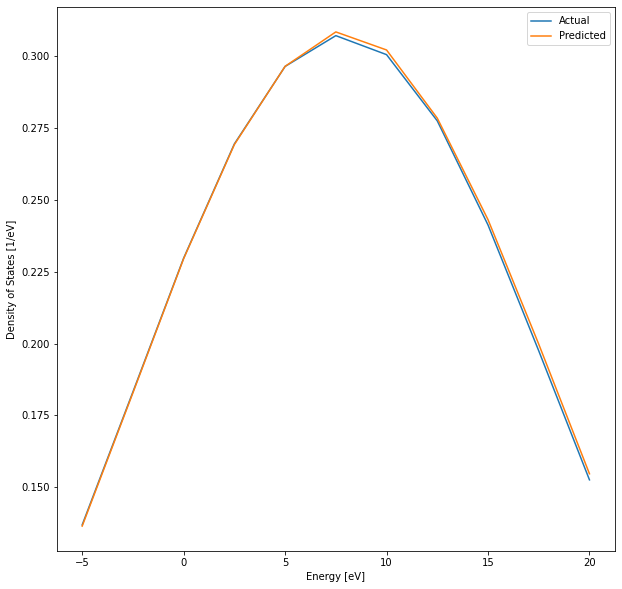

In [35]:
ldos_calculator = data_handler.target_calculator
ldos_calculator.read_additional_calculation_data(data_handler.get_snapshot_calculation_output(0))


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ldos_calculator.read_from_array(actual_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Actual")
ldos_calculator.read_from_array(predicted_ldos)
ax.plot(ldos_calculator.energy_grid, ldos_calculator.density_of_states.copy(), label="Predicted")

ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Density of States [1/eV]")
ax.legend()


This finally leads us to the prediction part - the part, to which such efforts eventually should culminate too. Since this part again requires LAMMPS, it will not be hands-on.

Instead I will demonstrate how MALA can be used to predict the electronic density and electronic structure of a system far larger the atomic configurations it was trained on. As we have demonstrated in a recently submitted research article, this is feasible if the training data is big enough to capture characteristic electronic effects. This is technically not the case with this reduced data set, but it is the case for production-level models and the syntax is the same regardless.

Before we predict models it should be noted that for production settings, it is very useful to save some simulation output alongside the model, so the predictor knows about, e.g., grid coarseness and such.


In [22]:
trainer.save_run("Be_model", additional_calculation_data=pj(data_path, "Be_snapshot2.out"))

In [27]:
parameters, network, data_handler, predictor = mala.Predictor.load_run("Be_model")
Be16 = read("Be16.vasp")
predicted_ldos = predictor.predict_for_atoms(Be16)

Descriptor calculation: had to enforce periodic boundary conditions on 0 atoms before calculation.
Had to readjust batch size from 40 to 48


Now that we have the LDOS we can calculate the total energy and electronic density. The latter can be visualized using e.g. VESTA.

In [7]:
# For the total energy calculation we need to tell MALA where to find a pseudopotential.

parameters.targets.pseudopotential_path = "./data_generation/"
ldos_calculator = predictor.target_calculator
ldos_calculator.read_from_array(predicted_ldos)
print(ldos_calculator.total_energy)
density_calculator = mala.Density.from_ldos_calculator(ldos_calculator)
density_calculator.write_to_cube("Be16_density.cube")


MALA: Starting QuantumEspresso to get density-based energy contributions.

time used by total energy initialization:  0.3680173630000354
MALA: QuantumEspresso setup done.
     Program PWSCF v.6.4.1 starts on 15Mar2023 at 17: 6:30 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI), running on     1 processors

     MPI processes distributed on     1 nodes
     Reading input from mala.pw.scf.in

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angular momentum in pseudopo

/home/fiedlerl/codes/mala/mala/common/parallelizer.py:235: UserWarning: Using 1D density to calculate the total energy requires reshaping of this data. This is unproblematic, as long as you provided the correct grid_dimensions.
  warnings.warn(warning, category=category)


That all seems nice and well, but a bit complicated in practice. Some or many of you may have worked with ASE calculators in the past. ASE is an incredibly useful library that provides direct interfaces to a lot of electronic structure codes. By providing a unified interface to access properties of interest (such as the total energy) it is easy to investigate the electronic structure of compounds.

Thus, MALA also provides an interface for this.


In [8]:
calculator = mala.MALA.load_model("Be_model", pj(data_path, "Be_snapshot2.out"))
calculator.mala_parameters.targets.pseudopotential_path = "./data_generation/"
Be16.set_calculator(calculator)
print(Be16.get_potential_energy())


Descriptor calculation: had to enforce periodic boundary conditions on 0 atoms before calculation.
MALA: QuantumEspresso is already running. Except for the atomic positions, no new parameters will be used.
time used by set_positions:  0.048365369000748615
time used by set_rho_of_r:  0.03205540999988443
-582.515180723934


Such calculators can now in principle be used like any electronic structure tool.
Currently, MALA cannot evaluate ionic forces. This is a topic of ongoing implementation, planned to be finished this summer. Thermodynamic sampling is possible via Monte-Carlo sampling, the limitations of which are currently researched.
For a set of ionic positions (obtained e.g. via a standard ML-IAP) MALA can be used to predict DOS, electronic density, LDOS, etc.

# Making MALA performant (presentation only)

Now that we know how to build and use MALA models the important question of scalability and performance arises.

There are two important things to test out here. One is optimizing performance of fitting models.
For this, the common practice (not just for MALA, but for ML in general) is using GPUs. I will shortly demonstrate how much this can help. Let us consider a model with 1000 neurons in one single layer.

In [18]:
parameters = mala.Parameters()
parameters.verbosity = 0
parameters.manual_seed = 2023
parameters.running.max_number_epochs = 5

data_handler = mala.DataHandler(parameters)
data_handler.clear_data()
data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                          "Be_snapshot0.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot2.in.npy", data_path,
                          "Be_snapshot2.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot3.in.npy", data_path,
                          "Be_snapshot3.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  1000, 1000,
                                  data_handler.output_dimension]

start_time = time()
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()
print("Training time:", time()-start_time)

Consistency check successful.
Data scalers initialized.
Build dataset: Done.
Final validation data loss:  5.188130906649998e-06
Training time: 118.33006763458252


And now let's do the same with GPU enabled!

In [19]:
parameters = mala.Parameters()
parameters.verbosity = 0
parameters.manual_seed = 2023
parameters.running.max_number_epochs = 5
parameters.use_gpu = True

data_handler = mala.DataHandler(parameters)
data_handler.clear_data()
data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                          "Be_snapshot0.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot2.in.npy", data_path,
                          "Be_snapshot2.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot3.in.npy", data_path,
                          "Be_snapshot3.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  1000, 1000,
                                  data_handler.output_dimension]

start_time = time()
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()
print("Training time:", time()-start_time)

Consistency check successful.
Data scalers initialized.
Build dataset: Done.
Final validation data loss:  5.18813037446567e-06
Training time: 15.947985410690308


That's already a fair bit of speed-up! The speed-up may not seem all to substantial here, which is due to the fact that we are using small amounts of data here. For larger data sets, the speed-up will be much bigger.

Advanced GPU utilization (beyond what pytorch supports by default, kindly implemented for us by experts from Nvidia) can give an even better speed-up.

In [20]:
parameters = mala.Parameters()
parameters.verbosity = 0
parameters.manual_seed = 2023
parameters.running.max_number_epochs = 5
parameters.use_gpu = True
parameters.running.use_graphs = True
parameters.data.use_fast_tensor_data_set = True

data_handler = mala.DataHandler(parameters)
data_handler.clear_data()

data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                          "Be_snapshot0.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot2.in.npy", data_path,
                          "Be_snapshot2.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot3.in.npy", data_path,
                          "Be_snapshot3.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes = [data_handler.input_dimension,
                                  1000, 1000,
                                  data_handler.output_dimension]

start_time = time()
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)
trainer.train_network()
print("Training time:", time()-start_time)

Consistency check successful.
Data scalers initialized.
Build dataset: Done.
Final validation data loss:  5.208891954963485e-06
Training time: 5.0542542934417725


Secondly, we'd like to optimize inference. Ideally, we would like to perform the entire inference on GPU. For MALA, this includes the calculation of the bispectrum descriptors as well as the LDOS integration / DFT energy evaluation. This is currently in development, so for now acceleration of inference is done via CPU parallelization. This is realized via MPI and since this is not easily shown in a jupyter notebook, this repository contains the `test_inference_mpi.py` script to this end, at which we will have a look now.


A final concept we may need is lazy loading. Lazy loading means that not all of the data can be loaded into RAM at the same time. This may happen sooner than you'd think or like, since data sets can be quite extensive. Of course for our small training examples this technically would not be a problem, but it can very well happen for huge data sets, so let us see what it entails.


In [25]:
parameters = mala.Parameters()
parameters.verbosity = 0
parameters.manual_seed = 2023
parameters.network.layer_sizes = [100]
parameters.running.max_number_epochs = 100
parameters.input_rescaling_type = "feature-wise-standard"
parameters.output_rescaling_type = "normal"
parameters.data.use_lazy_loading = True

data_handler = mala.DataHandler(parameters)
data_handler.clear_data()

data_handler.add_snapshot("Be_snapshot0.in.npy", data_path,
                          "Be_snapshot0.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot2.in.npy", data_path,
                          "Be_snapshot2.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot3.in.npy", data_path,
                          "Be_snapshot3.out.npy", data_path, "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes.insert(0, data_handler.input_dimension)
parameters.network.layer_sizes.append(data_handler.output_dimension)
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)

start_time = time()
trainer.train_network()
print("Training time:", time()-start_time)

Consistency check successful.
Data scalers initialized.
Build dataset: Done.
Final validation data loss:  2.9018478734152658e-06
Training time: 101.46236228942871


Of course, that can lead to problems with data shuffling. Ideally, within ML, we'd like to randomize the order in which data points are processed. In all of the models we have trained so far this had been the case, since they had all been loaded into RAM and randomized there. It had been done under the hood. But if we never load all of the data at the same time, how do we ensure random access?

The best solution for this problem is to shuffle your data before you load it. MALA provides a distinct class for this, but you may handle this however you'd like.

Just remember: Always randomize your data!



In [18]:
parameters.data.shuffling_seed = 1234

data_shuffler = mala.DataShuffler(parameters)
data_shuffler.clear_data()
data_shuffler.add_snapshot("Be_snapshot0.in.npy", data_path,
                           "Be_snapshot0.out.npy", data_path)
data_shuffler.add_snapshot("Be_snapshot2.in.npy", data_path,
                           "Be_snapshot2.out.npy", data_path)
data_shuffler.add_snapshot("Be_snapshot3.in.npy", data_path,
                           "Be_snapshot3.out.npy", data_path)
data_shuffler.shuffle_snapshots(complete_save_path="./",
                                save_name="Be_shuffled*")




Data shuffler will generate 3 new snapshots.
Shuffled snapshot dimension will be  (18, 18, 27)


In [24]:
parameters = mala.Parameters()
parameters.verbosity = 0
parameters.manual_seed = 2023
parameters.network.layer_sizes = [100]
parameters.running.max_number_epochs = 100
parameters.input_rescaling_type = "feature-wise-standard"
parameters.output_rescaling_type = "normal"
parameters.data.use_lazy_loading = True

data_handler = mala.DataHandler(parameters)
data_handler.clear_data()

data_handler.add_snapshot("Be_shuffled0.in.npy", "./",
                          "Be_shuffled0.out.npy", "./", "tr")
data_handler.add_snapshot("Be_shuffled1.in.npy", "./",
                          "Be_shuffled1.out.npy", "./", "tr")
data_handler.add_snapshot("Be_shuffled2.in.npy", "./",
                          "Be_shuffled2.out.npy", "./", "tr")
data_handler.add_snapshot("Be_snapshot1.in.npy", data_path,
                          "Be_snapshot1.out.npy", data_path, "va")

# This already loads data into RAM!
data_handler.prepare_data()
parameters.network.layer_sizes.insert(0, data_handler.input_dimension)
parameters.network.layer_sizes.append(data_handler.output_dimension)
network = mala.Network(parameters)
trainer = mala.Trainer(parameters, network, data_handler)

start_time = time()
trainer.train_network()
print("Training time:", time()-start_time)


Consistency check successful.
Data scalers initialized.
Build dataset: Done.
Final validation data loss:  2.8568131050893238e-06
Training time: 105.91155672073364
